In [1]:
## general imports
import json
import numpy as np

## COCO imports
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.cocoanalyze import COCOanalyze

## plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as io

In [2]:
## set paths
dataDir  = '.'
dataType = 'testdev2015'
annType  = 'keypoints'
teamName = 'maskrnn9' #maskrnn9 cmu

annFile  = '%s/annotations/%s_%s.json'%(dataDir, annType, dataType)
resFile  = '%s/detections/%s_%s_%s_results.json'%(dataDir, teamName, annType, dataType)

print("{:10}[{}]".format('annFile:',annFile))
print("{:10}[{}]".format('resFile:',resFile))

gt_data   = json.load(open(annFile,'rb'))
imgs_info = {i['id']:{'id':i['id'] ,
                      'width':i['width'],
                      'height':i['height']}
                       for i in gt_data['images']}

annFile:  [./annotations/keypoints_testdev2015.json]
resFile:  [./detections/maskrnn9_keypoints_testdev2015_results.json]


In [3]:
team_dts = json.load(open(resFile,'rb'))
team_dts = [d for d in team_dts if d['image_id'] in imgs_info]
team_img_ids = set([d['image_id'] for d in team_dts])
print("Loaded [{}] instances in [{}] images.".format(len(team_dts),len(imgs_info)))

Loaded [242657] instances in [20288] images.


In [4]:
sigmas = np.array([.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0

In [5]:
_dts = {}
for d in team_dts:
    if d['image_id'] in _dts:
        _dts[d['image_id']].append(d)
    else:
        _dts[d['image_id']] = [d]
print len(_dts)

18709


In [6]:
def computeOks(imgId):
    dts_1 = _dts[imgId]
    dts_2 = _dts[imgId]
    if len(dts_1) == 0:
        return []

    inds = np.argsort([-d['score'] for d in dts_1], kind='mergesort')
    dts_1 = [dts_1[i] for i in inds]
    dts_2 = [dts_2[i] for i in inds]

    ious = np.zeros((len(dts_1), len(dts_2)))
    vars = (sigmas * 2)**2
    k = len(sigmas)

    # compute oks between each detection and ground truth object
    for j, dt1 in enumerate(dts_1):
        # create bounds for ignore regions(double the gt bbox)
        d1 = np.array(dt1['keypoints'])
        xd1 = d1[0::3]; yd1 = d1[1::3]
        x0,x1,y0,y1 = np.min(xd1), np.max(xd1), np.min(yd1), np.max(yd1)
        area1 = (x1-x0)*(y1-y0)

        for i, dt2 in enumerate(dts_2):
            d2 = np.array(dt2['keypoints'])
            xd2 = d2[0::3]; yd2 = d2[1::3]
            x0,x1,y0,y1 = np.min(xd2), np.max(xd2), np.min(yd2), np.max(yd2)
            area2 = (x1-x0)*(y1-y0)
            area=.5*(area1+area2)
            
            dx = xd2 - xd1
            dy = yd2 - yd1
            
            e = (dx**2 + dy**2) / vars / (area+np.spacing(1)) / 2

            ious[i, j] = np.sum(np.exp(-e)) / e.shape[0]
    return ious

def computeOks1(imgId):
    dts_1 = _dts[imgId]
    dts_2 = _dts[imgId]
    if len(dts_1) == 0:
        return []

    inds = np.argsort([-d['score'] for d in dts_1], kind='mergesort')
    dts_1 = [dts_1[i] for i in inds]
    dts_2 = [dts_2[i] for i in inds]

    ious = np.zeros((len(dts_1), len(dts_2)))
    vars = (sigmas * 2)**2
    k = len(sigmas)

    # compute oks between each detection and ground truth object
    for j, dt1 in enumerate(dts_1):
        # create bounds for ignore regions(double the gt bbox)
        d1 = np.array(dt1['keypoints'])
        xd1 = d1[0::3]; yd1 = d1[1::3]
        x0,x1,y0,y1 = np.min(xd1), np.max(xd1), np.min(yd1), np.max(yd1)
        area1 = (x1-x0)*(y1-y0)

        for i, dt2 in enumerate(dts_2):
            d2 = np.array(dt2['keypoints'])
            xd2 = d2[0::3]; yd2 = d2[1::3]
            
            dx = xd2 - xd1
            dy = yd2 - yd1
            
            e = (dx**2 + dy**2) / vars / (area1+np.spacing(1)) / 2

            ious[i, j] = np.sum(np.exp(-e)) / e.shape[0]
    return ious

In [7]:
oks   =  {(imgId): computeOks(imgId) \
          for imgId in team_img_ids}

oks_1 =  {(imgId): computeOks1(imgId) \
          for imgId in team_img_ids}

In [9]:
idx = 1
# for k in oks_1.keys():
#     assert(np.all(oks_1[k]==oks_2[k].T))
print oks[oks.keys()[idx]], oks[oks.keys()[idx]].shape
print oks_1[oks_1.keys()[idx]], oks_1[oks_1.keys()[idx]].shape

x = []
y = []
z = []
for k in oks.keys():
    for i in xrange(oks[k].shape[0]):
        for j in xrange(i+1,oks[k].shape[1]):
            x.append(oks[k][i,j])
            y.append(oks_1[k][i,j])
            z.append(oks_1[k][j,i])
#             print i,j
#     assert(False)

[[  1.00000000e+000   4.36550170e-253   0.00000000e+000   1.59107786e-214
    5.36971252e-102   1.61093839e-252]
 [  4.36550170e-253   1.00000000e+000   3.33615033e-001   0.00000000e+000
    0.00000000e+000   4.67242822e-319]
 [  0.00000000e+000   3.33615033e-001   1.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000]
 [  1.59107786e-214   0.00000000e+000   0.00000000e+000   1.00000000e+000
    2.85978211e-103   0.00000000e+000]
 [  5.36971252e-102   0.00000000e+000   0.00000000e+000   2.85978211e-103
    1.00000000e+000   2.90827308e-140]
 [  1.61093839e-252   4.67242822e-319   0.00000000e+000   0.00000000e+000
    2.90827308e-140   1.00000000e+000]] (6, 6)
[[  1.00000000e+000   1.62443502e-225   0.00000000e+000   0.00000000e+000
    2.69098074e-103   2.67058629e-159]
 [  2.05281494e-288   1.00000000e+000   2.47821095e-001   0.00000000e+000
    0.00000000e+000   1.74509489e-212]
 [  5.27517339e-296   3.77100650e-001   1.00000000e+000   0.00000000e+000
    0.00000000

[[ 1.          0.98818476]
 [ 0.98818476  1.        ]]


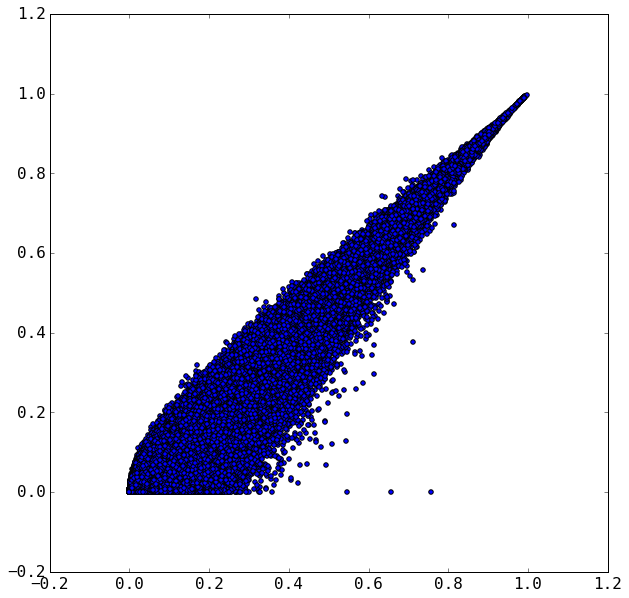

In [10]:
print np.corrcoef(x,y)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.show()

[[ 1.          0.99049224]
 [ 0.99049224  1.        ]]


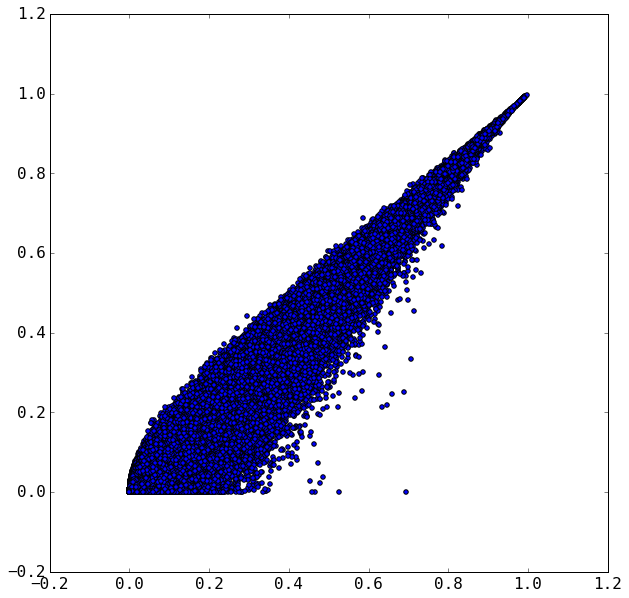

In [11]:
print np.corrcoef(x,z)
plt.figure(figsize=(10,10))
plt.scatter(x,z)
plt.show()

[[ 1.          0.96118577]
 [ 0.96118577  1.        ]]


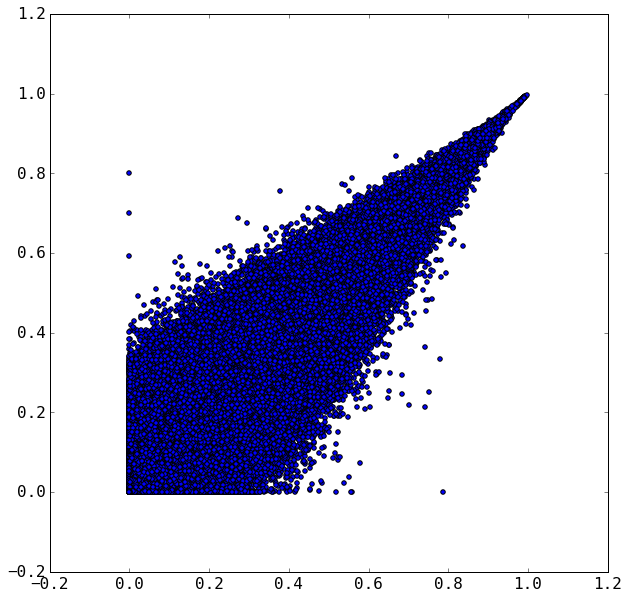

In [12]:
print np.corrcoef(y,z)
plt.figure(figsize=(10,10))
plt.scatter(y,z)
plt.show()

In [ ]:
print len(coco_analyze.cocoEval.ious.keys())
indx = 1
print coco_analyze.cocoEval.ious[coco_analyze.cocoEval.ious.keys()[indx]].shape
print coco_analyze.cocoEval.ious[coco_analyze.cocoEval.ious.keys()[indx]]

In [ ]:
dd = [d for d in coco_analyze.corrected_dts['medium'] if d['image_id']==466319]
print len(dd)

In [ ]:
for d in coco_analyze.corrected_dts['medium'][:10]:
    print d
    print

In [ ]:
weird = {}
for d in coco_analyze.corrected_dts['medium']:
    for oks in [.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]:
        if d['id'] in coco_analyze.false_pos_dts['medium',oks] and d['opt_score']!=0:
            if oks in weird:
                weird[oks].append(d)
            else:
                weird[oks] = [d]
                
for l in weird:
    print l, len(weird[l])
    
print weird[.95][0]

In [ ]:
for k in coco_analyze.false_pos_dts: print k, len(coco_analyze.false_pos_dts[k]), type(coco_analyze.false_pos_dts[k])
print "============"
for d in list(coco_analyze.false_pos_dts['medium',.6])[:10]: print d

In [ ]:
print type(coco_analyze.corrected_dts), len(coco_analyze.corrected_dts)
print coco_analyze.corrected_dts.keys()

print type(coco_analyze.localization_matches), len(coco_analyze.localization_matches)
print coco_analyze.localization_matches.keys()

In [ ]:
## after analyze() has been called the following variables are available

# list of the corrected detections
corrected_dts = coco_analyze.corrected_dts

i = 17
# info on keypoint detection localization error
print 'good: %s'%corrected_dts[i]['good']
print 'miss: %s'%corrected_dts[i]['miss']
print 'swap: %s'%corrected_dts[i]['swap']
print 'inv.: %s'%corrected_dts[i]['inversion']
print 'jit.: %s\n'%corrected_dts[i]['jitter']

# corrected keypoint locations
print 'predicted keypoints:\n %s'%corrected_dts[i]['keypoints']
print 'corrected keypoints:\n %s\n'%corrected_dts[i]['opt_keypoints']

# optimal detection score
print 'original score: %s'%corrected_dts[i]['score']
print 'optimal score:  %s\n'%corrected_dts[i]['opt_score']

# dictionary with all detection and ground truth matches
dt_gt_matches = coco_analyze.matches
print "Dt-gt match:"
for k in dt_gt_matches['dts'][corrected_dts[i]['id']][0]:
    print k, dt_gt_matches['dts'][corrected_dts[i]['id']][0][k]

In [ ]:
## after summarize() has been called the following variables are available

# list of the missed ground-truth annotations
false_neg_gts = coco_analyze.false_neg_gts

In [ ]:
## list the performance summary 
for stat in coco_analyze.stats: print stat